# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map
from utils.metrics import *
import glob
import os
import re

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,    # 0.01 o 0.001 
        "epochs": 200,    # Echar un vistazo a loss y ver si se estabiliza (a lo mejor converge con 50 épocas)
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1,
        "batch_size": 100
}

In [3]:
torch.manual_seed(params["seed"])
dataset = get_dataset("Energy", random_state=params["seed"])

In [4]:
# Ruta base de tu carpeta energy
base_path = "energy"

# Patrón para encontrar todos los archivos *_metrics_fold_*.csv
pattern = os.path.join(base_path, "*_metrics_fold_*.csv")
files = glob.glob(pattern)

# Diccionario para almacenar los DataFrames por método
method_dfs = {}

# Expresión regular para extraer método y número de fold
regex = re.compile(r"([^/\\]+)_metrics_fold_(\d+)\.csv$")

for file in files:
    match = regex.search(file)
    if match:
        method = match.group(1)  # p.ej., "kron" o "lastlayer_lla"
        fold = int(match.group(2))

        # Leer el CSV
        df = pd.read_csv(file)

        # Añadir columna de fold
        df["fold"] = fold

        # Guardar en el diccionario
        if method not in method_dfs:
            method_dfs[method] = []
        method_dfs[method].append(df)

# Convertir cada lista de DataFrames en un único DataFrame por método
for method in method_dfs:
    method_df = pd.concat(method_dfs[method], ignore_index=True)
    # Ordenar por fold para que la tabla esté limpia
    method_df = method_df.sort_values("fold").reset_index(drop=True)
    method_dfs[method] = method_df

# Ahora puedes acceder a cada tabla así:
for method, df in method_dfs.items():
    print(f"\n--- Resultados para {method} ---")
    print(df)


--- Resultados para lastlayer_lla ---
        RMSE        NLL      Q-10      Q-20      Q-30      Q-40      Q-50  \
0   1.224940  15.468401  0.000000  0.025641  0.025641  0.076923  0.102564   
1   1.064861  11.952829  0.000000  0.000000  0.000000  0.051282  0.076923   
2   1.592302  17.266861  0.000000  0.025641  0.051282  0.076923  0.102564   
3   1.233248  20.452579  0.000000  0.000000  0.000000  0.000000  0.000000   
4   1.111237  12.749402  0.025641  0.025641  0.076923  0.128205  0.153846   
5   1.018385  12.774208  0.051282  0.051282  0.051282  0.128205  0.179487   
6   0.924606   9.357955  0.025641  0.051282  0.051282  0.076923  0.076923   
7   1.343948  16.467199  0.000000  0.000000  0.000000  0.000000  0.000000   
8   1.318541  23.314313  0.026316  0.026316  0.026316  0.052632  0.078947   
9   0.886730   9.239275  0.000000  0.052632  0.131579  0.131579  0.157895   
10  0.875026   9.447408  0.026316  0.052632  0.052632  0.052632  0.052632   
11  1.090972  13.349848  0.000000  0.

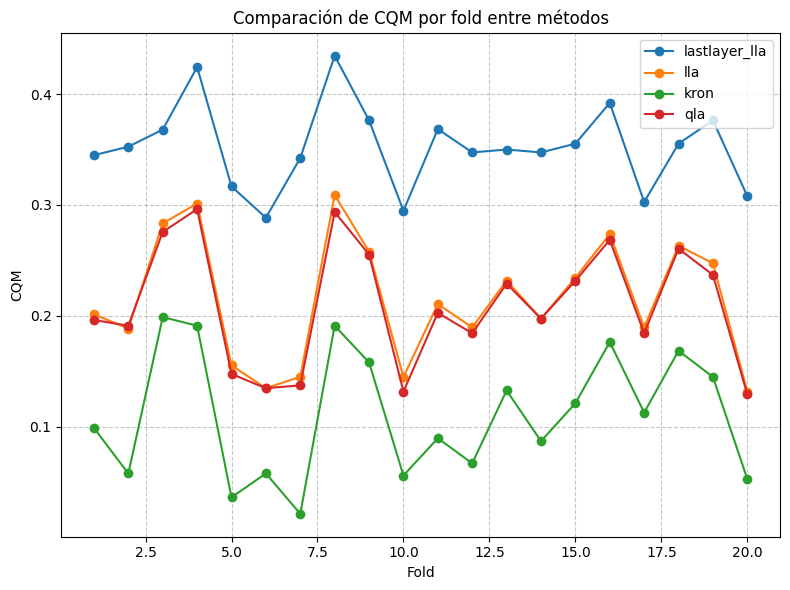

In [5]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CQM" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CQM"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CQM")
plt.title("Comparación de CQM por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

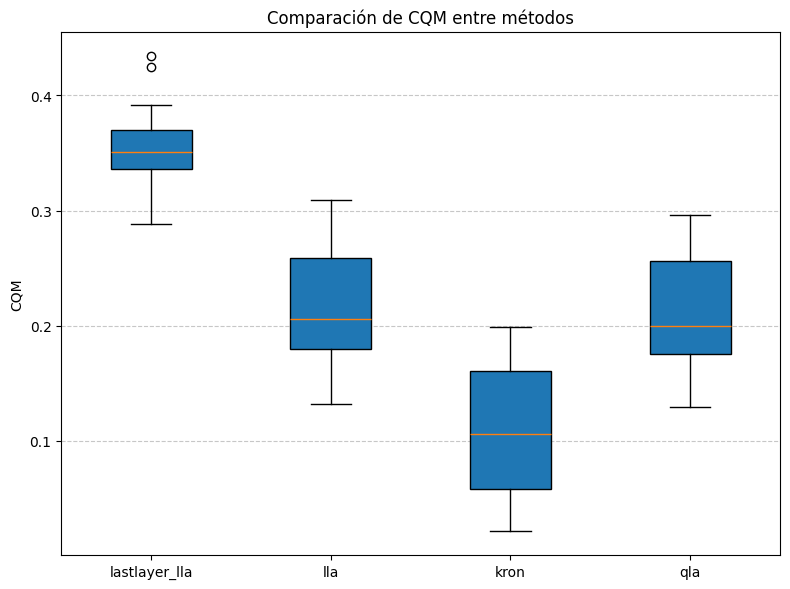

In [6]:
# Extraer datos de CQM para todos los métodos disponibles
data = []
labels = []

for method, df in method_dfs.items():
    if "CQM" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CQM"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CQM")
plt.title("Comparación de CQM entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

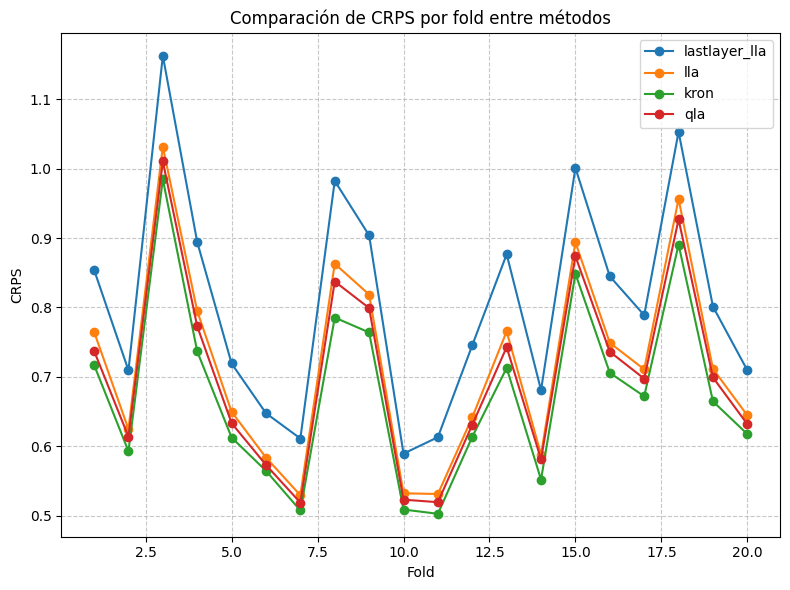

In [7]:
plt.figure(figsize=(8, 6))

for method, df in method_dfs.items():
    if "CRPS" in df.columns and "fold" in df.columns:
        plt.plot(df["fold"], df["CRPS"], marker="o", label=method)

plt.xlabel("Fold")
plt.ylabel("CRPS")
plt.title("Comparación de CRPS por fold entre métodos")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

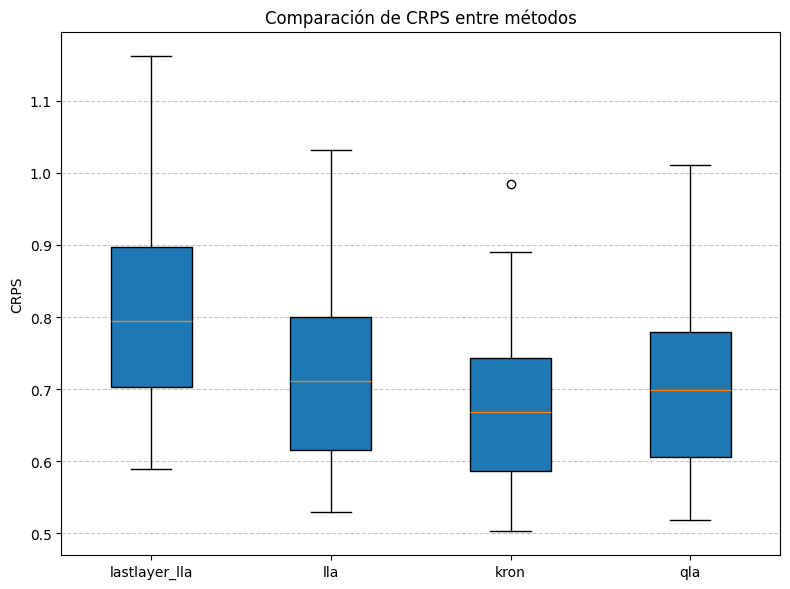

In [8]:
# Extraer datos de CQM para todos los métodos disponibles
data = []
labels = []

for method, df in method_dfs.items():
    if "CRPS" in df.columns:  # Asegurarse de que existe la métrica
        data.append(df["CRPS"])
        labels.append(method)

plt.figure(figsize=(8, 6))
plt.boxplot(data, tick_labels=labels, patch_artist=True)

plt.ylabel("CRPS")
plt.title("Comparación de CRPS entre métodos")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()